In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math
import librosa
import os

Data processing parameters 

In [2]:
fs = 44100                  # Hz, sampling frequency
f_size = 512                # Frame size
h_size = int(f_size/2)      # Hop size
supra_frame_duration = 0.5  # seconds
frame_num_gl = round(supra_frame_duration / (h_size/fs))
data = np.zeros((100, h_size, frame_num_gl))

In [3]:
dir_HC = 'wav'+ os.sep + 'HC' + os.sep
dir_ALS = 'wav' + os.sep + 'ALS' + os.sep
directory_ALS = os.listdir(dir_ALS)
directory_HC = os.listdir(dir_HC)

Mel-frequency spectrogramm (example)

In [34]:
def stft_analysis(x, f_size, h_size):
    Ln = x.shape[0]                                 # signal length
    frame_num = math.floor((Ln-f_size)/h_size + 1)  # number of frames      

    wnd = np.hamming(f_size)

    spec = np.zeros((h_size,frame_num))

    for N in range(frame_num):
        x_frame = x[h_size*N: h_size*N + f_size]
        x_wnd = x_frame*wnd

        X = np.fft.fft(x_wnd)
        X_abs = np.abs(X[0:h_size])

        spec[:,N] = X_abs
        # spec[:,N] = np.log(X_abs)
    return spec

Text(0, 0.5, '$\\log(|X(k,m)|)$')

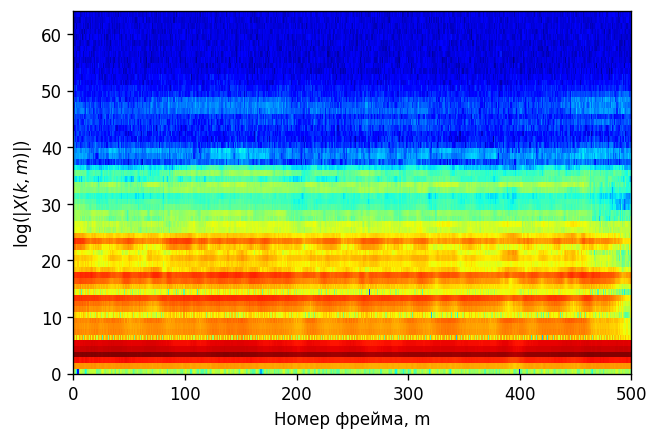

In [39]:
fileName = 'wav/HC/002_a.wav'
x, sr = librosa.load(fileName, sr=None, mono=True, offset=0.0, duration=None)

# Variant 1
S = librosa.feature.melspectrogram(y=x, sr=sr, n_mels=64, n_fft=f_size, hop_length=h_size, window='hamming', center=False,power=1.0)
S1 = 20*np.log10(S)

# Variant 2
X = stft_analysis(x, f_size, h_size)
S = librosa.feature.melspectrogram(y=None,S=X, n_mels=64, power=1.0)
S2 = 20*np.log10(S)

plt.subplots(dpi=120)
plt.subplot(121)
plt.pcolor(S1,shading='flat',cmap='jet')
plt.xlabel('Номер фрейма, m')
plt.ylabel('$\log(|X(k,m)|)$')

plt.subplot(122)
plt.pcolor(S2,shading='flat',cmap='jet')
plt.xlabel('Номер фрейма, m')
plt.ylabel('$\log(|X(k,m)|)$')

Analysing cycle

In [21]:
# freq = np.linspace(0, sr/2, h_size)
X = np.zeros((50000,S.shape[0],frame_num_gl))   # data
y = np.zeros((50000,1))                     # labels
X_global_index = 0
X_ids = list([])
# Cycle for HC (helthy controls)
for i in range(len(directory_HC)):    
    if directory_HC[i][-5:]=='a.wav':
        print(directory_HC[i][-5:])
        fileName = dir_HC + directory_HC[i]
        x, sr = librosa.load(fileName, sr=None, mono=True, offset=0.0, duration=None)

        X_melspec = librosa.feature.melspectrogram(y=x, sr=sr, n_mels=64, n_fft=f_size, hop_length=h_size, window='hann', center=False, power=1.0)
        X_melspec = 20*np.log10(X_melspec)
            
        frame_num = X_melspec.shape[1]    

        X_melspec = X_melspec.astype(np.half)
        X_melspec.tofile(dir_HC + directory_HC[i][:-4] +'_mel.dat')

#       #Запись фрагметов спектра в трехмерный массив 
        N_supra_frames = frame_num - frame_num_gl + 1

        # generator comprehension
        gen_range = (n * 2 for n in range(0, np.floor(N_supra_frames/2).astype(int)))
        for n in gen_range:
            X[X_global_index,:,:] = X_melspec[:,n:n+frame_num_gl]
            X_ids.append(int(directory_HC[i][0:3]))
            y[X_global_index] = 0
            X_global_index = X_global_index +1
    
# Cycle for ALS (pathology)
for i in range(len(directory_ALS)):
    if directory_ALS[i][-5:]=='a.wav':
        fileName = dir_ALS + directory_ALS[i]
        x, sr = librosa.load(fileName, sr=None, mono=True, offset=0.0, duration=None)

        X_melspec = librosa.feature.melspectrogram(y=x, sr=sr, n_mels=64, n_fft=f_size, hop_length=h_size, window='hann', center=False, power=1.0)
        X_melspec = 20*np.log10(X_melspec)
            
        frame_num = X_melspec.shape[1]
     
        X_melspec = X_melspec.astype(np.half)
        X_melspec.tofile(dir_ALS + directory_ALS[i][:-4] +'_mel.dat')

#       #Запись фрагметов спектра в трехмерный массив 
        N_supra_frames = frame_num - frame_num_gl + 1

        # generator comprehension
        gen_range = (n * 2 for n in range(0, np.floor(N_supra_frames/2).astype(int)))
        for n in gen_range:
            X[X_global_index,:,:] = X_melspec[:,n:n+frame_num_gl]
            X_ids.append(int(directory_ALS[i][0:3]))
            y[X_global_index] = 1
            X_global_index = X_global_index + 1


a.wav
a.wav
a.wav
a.wav
a.wav
a.wav
a.wav
a.wav
a.wav
a.wav
a.wav
a.wav
a.wav
a.wav
a.wav
a.wav
a.wav
a.wav
a.wav
a.wav
a.wav
a.wav
a.wav
a.wav
a.wav
a.wav
a.wav
a.wav
a.wav
a.wav
a.wav
a.wav
a.wav


Data for training

In [22]:
inds_to_delete = np.array(range(y.shape[0]))>=X_global_index
y = np.delete(y,inds_to_delete)
X = np.delete(X,inds_to_delete, axis=0)

Show general sample from dataset

Text(0, 0.5, '$\\log(|X(k,m)|)$')

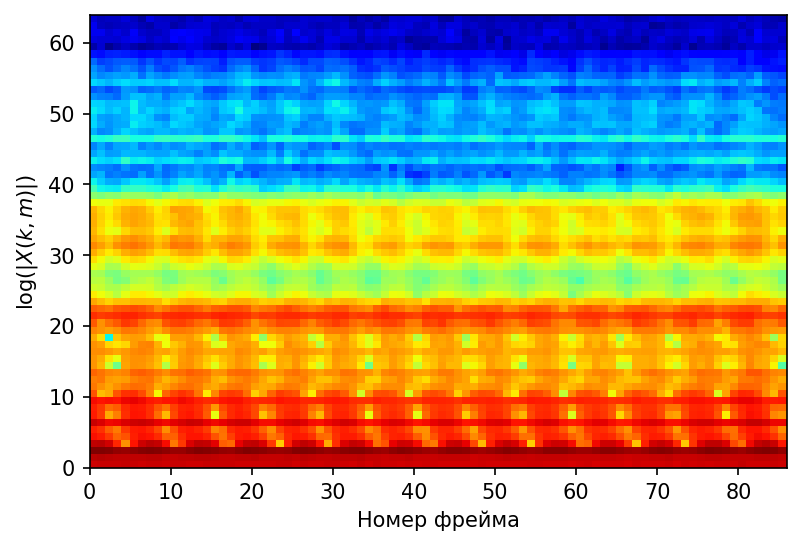

In [23]:
data_sample = X[2153,:,:]
plt.subplots(dpi=150)
plt.pcolor(data_sample,shading='flat',cmap='jet')
plt.xlabel('Номер фрейма')
plt.ylabel('$\log(|X(k,m)|)$')

In [17]:
# Bad variant of saving

# np.savez('data', X)
# np.savez('targets', y)

# Also bad variant of saving
# X2 = X.astype(np.half)
# y2 = y.astype(np.half)
# X2.tofile('data_X.dat')
# y2.tofile('data_y.dat')